In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax

In [2]:
# Setup RNG
key = jax.random.PRNGKey(42)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Merger Model (Generic Implicit Rotating Source)

In [3]:
def Q(s_fin_hat):
    return 2 / (1 - s_fin_hat)**0.45

In [4]:
def alpha(eta, s_fin_hat):
    return 1 / Q(s_fin_hat)**2 * (16313/562 + (21345/1244)*eta)

In [5]:
def b(eta):
    return 16014 / 979 - (29132 / 1343)*eta**2

In [6]:
def c(eta):
    return 206/903 + (180/1141) * jnp.sqrt(eta) + (424/1205) * (eta**2 / jnp.log(eta))

In [7]:
def kappa(eta):
    return 713/1056 - (23/193)*eta

In [8]:
def s_fin_hat(eta):
    """Final black hole spin"""
    return 2*jnp.sqrt(3)*eta - (390/79)*eta**2 + (2379/287)*eta**3 - (4621/276)*eta**4

In [9]:
def omega_qnm(s_fin_hat):
    """Fundamental frequency of the quasi-normal modes"""
    return 1-0.63*(1-s_fin_hat)**0.3

In [10]:
def f_hat(t, eta):
    c_ = c(eta)
    kappa_ = kappa(eta)
    b_ = b(eta)
    return (c_/2)*(1+1/kappa_)**(1+kappa_)*(1-(1 + (1/kappa_)*jnp.exp(-2*t/b_))**(-kappa_))

In [11]:
def f_hat_dot(t,eta):
    c_ = c(eta)
    kappa_ = kappa(eta)
    b_ = b(eta)
    return -(c_*((kappa_ + 1)/kappa_)**(kappa_+1)*jnp.exp(-2*t/b_)*((jnp.exp(-2*t/b_)+kappa_)/kappa_)**(-kappa_-1))/b_

In [12]:
def omega(t, eta, s_fin_hat):
    """Angular orbital velocity"""
    omega_qnm_ = omega_qnm(s_fin_hat)
    return omega_qnm_*(1-f_hat(t,eta))

In [13]:
def amplitude(t,eta, a0):
    s_fin_hat_ = s_fin_hat(eta)
    alpha_ = alpha(eta, s_fin_hat_)
    omega_t_ = omega(t,eta,s_fin_hat_)
    f_hat_ = f_hat(t,eta)
    f_hat_dot_ = f_hat_dot(t,eta)
    return a0 / omega_t_ * (jnp.abs(f_hat_dot_)/(1+alpha_*(f_hat_**2 - f_hat_**4)))**0.5

## Fitting/Optimization

In [14]:
# Generate some "measured data" with noise
N = 1000 # number of time samples
t = jnp.linspace(-100,100,N)
eta = 0.25 # Mass ratio
a0 = 1/0.35 # Peak amplitude
meas_a = amplitude(t,eta,a0) + jax.random.normal(key, (N,)) * 0.05

In [20]:
def fit(t,a):
    # Setup optimizer (common ML optimizer used here)
    optimizer = optax.adam(0.1)

    # Setup initial params (initial guess)
    params = jnp.array([0.1, 1.0])
    opt_state = optimizer.init(params)

    # Define loss function
    def loss(params):
        # Call the GW amplitude model on the current param estimate
        a_pred = amplitude(t,params[0],params[1])
        # Create a loss function via the mean squared error between the measured and predicted
        loss = jnp.mean(optax.l2_loss(a_pred, a))
        return loss

    # Setup the update rule for the optimization (JIT-compiled)
    @jax.jit
    def step(params, opt_state):
        ###### HERE'S WHERE THE AUTODIFF HAPPENS
        ###### Take the derivative of our loss function with respect to our parameters
        loss_value, grads = jax.value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    # Train!
    for i in range(501):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f"step {i}, loss: {loss_value}")

    return params

In [21]:
fit_params = fit(t,meas_a)

step 0, loss: 0.04241984337568283
step 100, loss: 0.0016269800253212452
step 200, loss: 0.0013477141037583351
step 300, loss: 0.0013131146552041173
step 400, loss: 0.001305324025452137
step 500, loss: 0.00130353809799999


Text(0, 0.5, 'Amplitude')

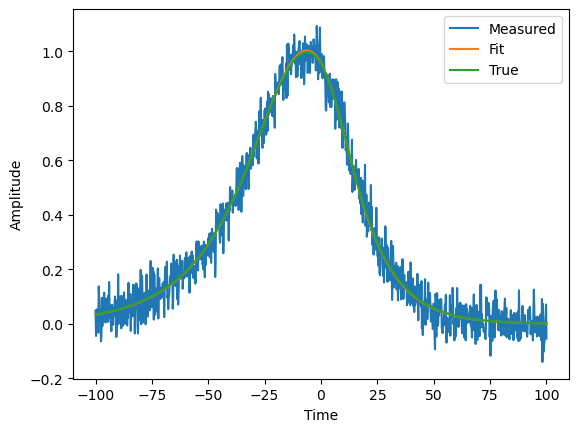

In [17]:
plt.plot(t,meas_a,label="Measured")
plt.plot(t,amplitude(t,fit_params[0], fit_params[1]),label="Fit")
plt.plot(t,amplitude(t,eta,a0),label="True")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")

Exercise for the reader to implement the phase terms, training against real data, etc.